In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from stingray import StingrayTimeseries, EventList, Lightcurve, Powerspectrum
import matplotlib.pyplot as plt


## Why using weights?

In some missions like Fermi, events are assigned a weight. The weight measures the probability that a given event is associated with the source, based on position and data quality.

In this tutorial, we go beyond the concept of count light curves and show how to use weighted event lists. We will use `StingrayTimeseries` objects, that allow for more flexibility than `Lightcurve`s.

Note that that weight can have any name. Here, we will call it `poids`, using the French term for `weight`


In [2]:
# The FOV is assumed to be a detector with 1000 x 1000 pixels
center = 50
# The source is right at the center, with a Gaussian spread of 10 pixels
pixel_spread = 3
min_pixel = 1
max_pixel = 100

# Create an event list with a pulsation
freq = 1.2
ampl = 1.

# Input Light curve characteristics
t0 = 0
t1 = 1000
# Dt should be smaller and not an integer divisor of the period
dt = 1 / np.sqrt(971*3) / freq
times = np.arange(t0 + dt/2, t1 - dt/2, dt)

# The actual number will be a random number, Poisson-distributed
raw_n_pulsed_counts = 2000
n_background_counts = np.random.poisson(200000)

# Normalize so that the sum gives the number of expected counts
continuous_pulsed_counts = (1 + ampl * np.sin(2 * np.pi * freq * times))
continuous_pulsed_counts /= np.sum(continuous_pulsed_counts)
continuous_pulsed_counts *= raw_n_pulsed_counts

# This light curve only serves the purpose of the simulation
continuous_pulsed_lc = Lightcurve(times, continuous_pulsed_counts, dt=dt, skip_checks=True)

pulsed_ev = EventList(gti=np.asarray([[t0, t1]]))
pulsed_ev.simulate_times(continuous_pulsed_lc)
n_pulsed_counts = pulsed_ev.time.size

unpulsed_ev = EventList(np.sort(np.random.uniform(t0, t1, n_background_counts)), gti=pulsed_ev.gti)

# Now, give each event a position. 
pulsed_ev.x = np.random.normal(center, pixel_spread, n_pulsed_counts)
pulsed_ev.y = np.random.normal(center, pixel_spread, n_pulsed_counts)

unpulsed_ev.x = np.random.uniform(min_pixel, max_pixel, n_background_counts)
unpulsed_ev.y = np.random.uniform(min_pixel, max_pixel, n_background_counts)

ev = pulsed_ev.join(unpulsed_ev)

# The weight is a probability that an event is from the source, given the 
# distance from the center of the FOV.
weight = 1 / (2 * np.pi * pixel_spread**2)*np.exp(-0.5 / pixel_spread**2 * ((ev.x - center)**2 + (ev.y - center)**2))
# weight[weight < 1e-10] = 0
ev.poids = weight


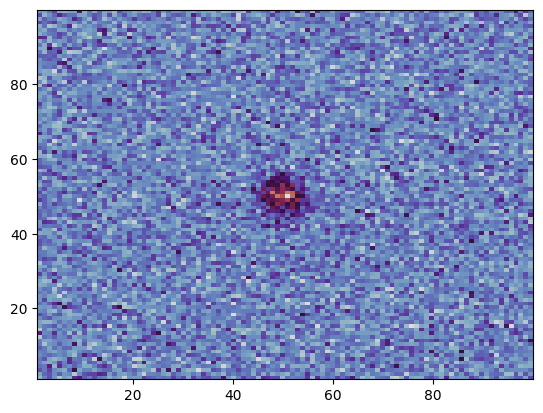

In [3]:
plt.hist2d(ev.x, ev.y, bins=100, cmap="twilight");

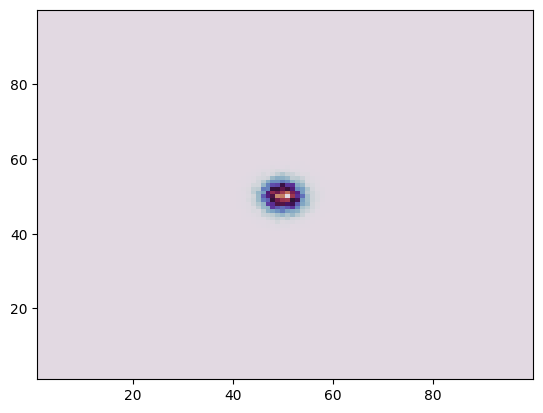

In [4]:
plt.hist2d(ev.x, ev.y, weights=ev.poids, bins=100, cmap="twilight");


Now, let us create a `StingrayTimeseries` object from this event list. 

By default, the `to_binned_timeseries` method calculates a series from the weighted sum of all attributes of the same length of `ev.time` (such as `x` and `y`), plus the number of counts per bin (like in `Lightcurve`).

However, one can specify a list of attributes to weigh on through the `array_attrs` keyword.

In [5]:
# Let's use a different dt
ts_dt = 1 / np.sqrt(89) / freq
ts_all = ev.to_binned_timeseries(ts_dt)
ts = ev.to_binned_timeseries(ts_dt, array_attrs={"poids"})

print("Attributes without the array_attrs keyword:", ts_all.array_attrs())
print("Attributes with the array_attrs keyword:", ts.array_attrs())

Attributes without the array_attrs keyword: ['counts', 'poids', 'x', 'y']
Attributes with the array_attrs keyword: ['counts', 'poids']


Since event lists might have many attributes, it is advisable to select which ones to transform in weights.

Giving an empty dictionary (`array_attrs={}`) creates something very similar to a standard `Lightcurve` 

Finally, for usage with `Powerspectrum`, let us assign a mean error for the weights. This will only work and make sense when the vast majority of events are from noise.

In [6]:
ts.poids_err = np.zeros_like(ts.poids) + np.std(ts.poids)


## Timing analysis using StingrayTimeseries

The timing analysis that can be done with a StingrayTimeseries object is very similar to the one doable with a `Lightcurve`. For example, we can call the `from_stingray_timeseries` method of `Powerspectrum`. 

Note that in this case we have to specify which attribute to use as flux (in the `from_lightcurve` method, `counts` was the default). For this, we use the `flux_attr` keyword.

We can also, optionally, specify another attribute which will serve as an error bar for those normalizations where it makes sense. For this, we use the `error_flux_attr` keyword.

In [7]:
ps_counts = \
    Powerspectrum.from_stingray_timeseries(ts, flux_attr="counts", norm="leahy")
ps_weighted = \
    Powerspectrum.from_stingray_timeseries(
        ts, flux_attr="poids", error_flux_attr="poids_err", norm="leahy")

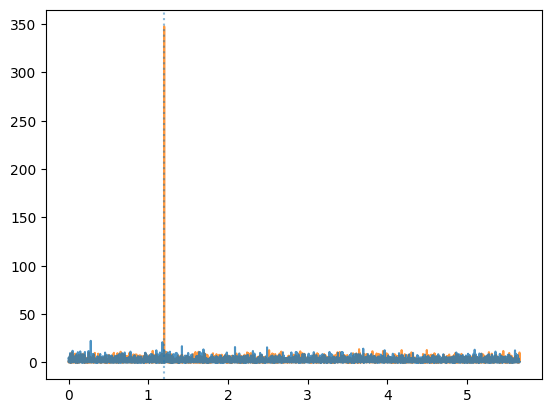

In [8]:
higher = ps_weighted.power.max() > ps_counts.power.max()

plt.plot(ps_counts.freq, 
         ps_counts.power, 
         ds="steps-mid", alpha=0.8, zorder=(10 if higher else 0))
plt.plot(ps_weighted.freq, 
         ps_weighted.power, 
         ds="steps-mid", alpha=0.8, zorder=(10 if not higher else 0))
plt.axvline(freq, ls=":", alpha=0.5)

(2, 703.694595637553)

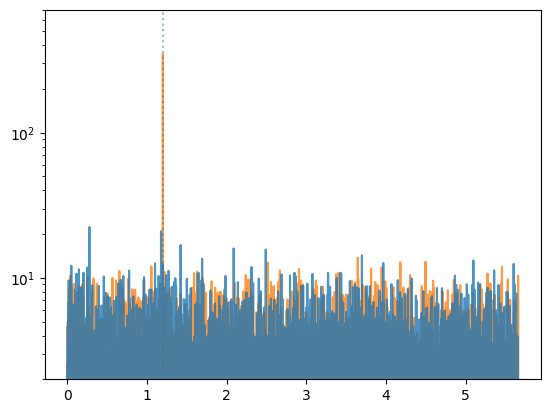

In [9]:
plt.plot(ps_counts.freq, 
         ps_counts.power, 
         ds="steps-mid", alpha=0.8, zorder=(10 if higher else 0))
plt.plot(ps_weighted.freq, 
         ps_weighted.power, 
         ds="steps-mid", alpha=0.8, zorder=(10 if not higher else 0))
plt.axvline(freq, ls=":", alpha=0.5)
plt.semilogy()
plt.ylim(2, None)

As we can see, the analysis using weights has found the pulsation whereas the one considering just the events hasn't.

This was a very trivial case, where the selection could have been done by just selecting events around the source position. But weights might take into account many other factors, such as the energy, the data quality, and more.


## Polarimetric light curves


Another case that might be useful is when we are looking for a pulsation not in the flux, but in some other quantity. This might be the case, for example, in polarimetric light curves.

In the following example, we introduce a significant periodic change of polarization in a signal which has no periodic modulation of the flux.


In [10]:
def extract_varying_random_photon_angles(photon_times, psi_mean=0, psi_amp=0, pd_mean=0, pd_amp=0, freq=1., n_bins_per_cycle=16, N =100):
    from scipy.interpolate import interp1d

    pulse_cycles = photon_times * freq
    pulse_cycle_frac = pulse_cycles - np.floor(pulse_cycles)
    order = np.argsort(pulse_cycle_frac)
    disordered_photon_times = photon_times[order]

    sorted_cycle_frac = pulse_cycle_frac[order]

    random_angles = np.zeros_like(photon_times)

    idx0 = 0
    delta_cycle_frac = 1 / n_bins_per_cycle
    angles = np.linspace(0, np.pi * 2, N + 1)[:-1]
    baseline = photon_times.size / n_bins_per_cycle
    A_mean = pd_mean * baseline
    A_amp = pd_amp * baseline
    for cycle_no in range(n_bins_per_cycle):
        idx1 = np.searchsorted(sorted_cycle_frac[idx0:], (1 + cycle_no) * delta_cycle_frac)

        sorted_cycle_frac_good = sorted_cycle_frac[idx0: idx0 + idx1]
        n_phot = sorted_cycle_frac_good.size
        mean_cycle_frac = (0.5 + cycle_no) * delta_cycle_frac
        A = A_mean + A_amp * np.cos(2 * np.pi * mean_cycle_frac)
        psi = psi_mean + psi_amp * np.cos(2 * np.pi * mean_cycle_frac)

        # TODO: be safe at edges of distribution
        # The distribution is the one expected for polarization angles.
        distr = A * np.cos(2 * (angles+ psi)) + baseline

        norm_distr = distr / distr.sum()
        dph = 1 / distr.size
        cdf = np.cumsum(norm_distr)
        cdf = np.concatenate(([0], cdf))

        interp = interp1d(cdf, np.arange(0, 1 + dph, dph) * (2 * np.pi), kind="cubic", fill_value="extrapolate")

        # Generate random values of polarization angle with the inverse CDF method.
        random_cdf_val = np.random.uniform(0, 1, n_phot)
        random_angles[idx0: idx0 + idx1] = interp(random_cdf_val)
        # Note that we searched from idx0 on
        idx0 += idx1

    order = np.argsort(disordered_photon_times)
    return random_angles[order]


def plot_angle_distribution_with_pulse_phase(photon_times, random_angles, freq):
    pulse_phase = (photon_times * freq)
    pulse_phase -= np.floor(pulse_phase)

    fig = plt.figure()
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0, height_ratios=[1, 2], width_ratios=[2, 1])
    # gs = plt.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[2, 1])

    (ax00, ax01), (ax10, ax11) = gs.subplots(sharex='col', sharey='row')

    h2, binsx, binsy, _ = ax10.hist2d(pulse_phase, random_angles, vmin=0, bins=(32, 16), cmap="twilight")
    ax10.set_ylabel(r"$\psi$")
    ax10.set_xlabel(r"Pulse phase")
    mean_binsx = (binsx[:-1] + binsx[:-1]) / 2
    mean_binsy = (binsy[:-1] + binsy[:-1]) / 2
    for i in range(h2.shape[1]):
        ax00.plot(mean_binsx, h2[:, i])
    for i in range(h2.shape[0]):
        ax11.plot(h2[i, :], mean_binsy)




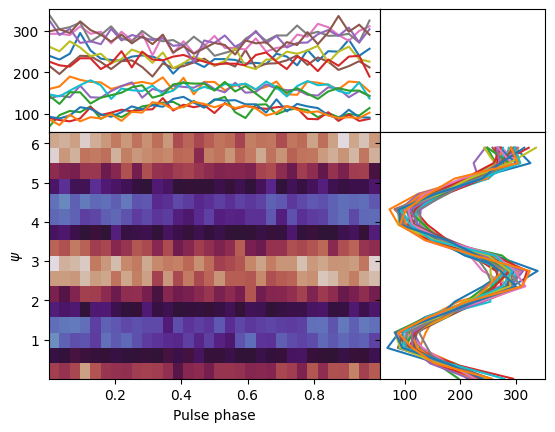

In [11]:
n_photons = 100000
psi_mean = np.radians(22.5)
# Photon times are completely random. No pulsation
photon_times = np.sort(np.random.uniform(t0, t1, n_photons))

# Here we generate polarization angles for all the photons
random_angles = extract_varying_random_photon_angles(
    photon_times, 
    psi_mean=psi_mean, 
    psi_amp=0, # No change of polarization angle
    pd_mean=0.5, # A mean polarization degree of 50%
    pd_amp=0.1, # A *change* of polarization degree by 10%
    freq=freq)

plot_angle_distribution_with_pulse_phase(photon_times, random_angles, freq)


The plot above shows the change of the modulation curve with pulse phase. Please note: there is no change of flux. There is no pulsation that can be seen in the here, in the pulsed profile (red bands indicate 1, 2, and 3 sigma deviations from the mean):

Text(0, 0.5, 'Counts')

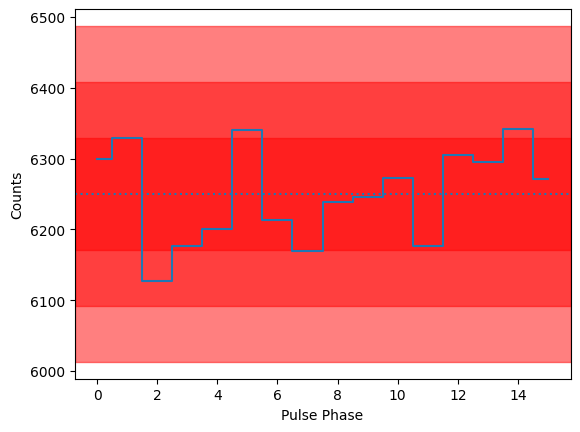

In [12]:
phases = (photon_times / freq) % 1

profile, _ = np.histogram(phases, bins=np.linspace(0, 1, 17))

mean = profile.mean()
for nsigma in range(1, 4):
    plt.axhspan(mean - nsigma * np.sqrt(mean), mean + nsigma * np.sqrt(mean), alpha=0.5, color="red")
plt.plot(profile, ds="steps-mid", zorder=10)
plt.axhline(mean, ls=":")
plt.xlabel("Pulse Phase")
plt.ylabel("Counts")

Now, let us put the polarimetric information in the form of Stokes parameters in an `EventList` object.

In [13]:
ev_polar = EventList(time=photon_times, gti=[[t0, t1]])
ev_polar.q = np.cos(2 * random_angles)
ev_polar.u = np.sin(2 * random_angles)

ts_polar = ev_polar.to_binned_timeseries(dt=ts_dt, array_attrs=["q", "u"])
ts_polar.array_attrs()

['counts', 'q', 'u']

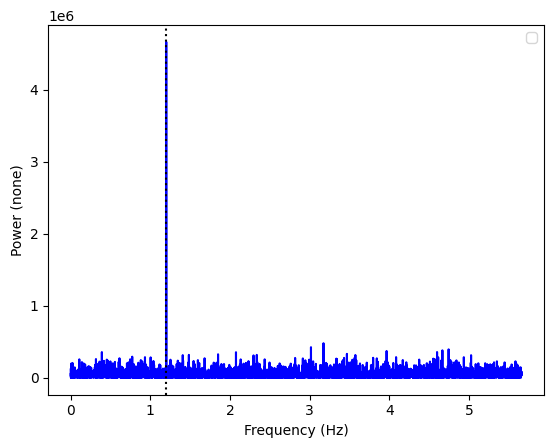

In [14]:
ax = Powerspectrum.from_stingray_timeseries(ts_polar, flux_attr="q").plot()
ax.axvline(freq, ls=":", color="k")

A pulsation in the Q Stokes parameter! Let us see the U parameter:

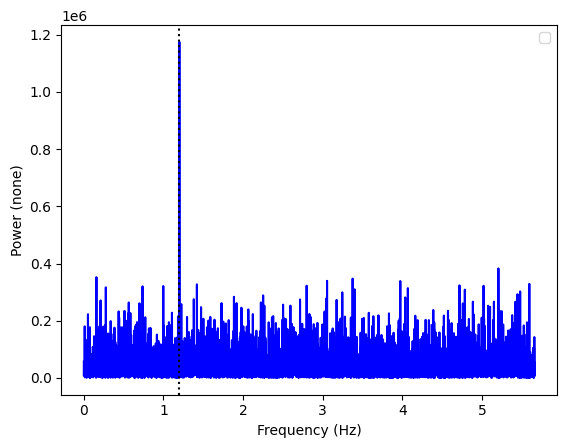

In [15]:
ax = Powerspectrum.from_stingray_timeseries(ts_polar, flux_attr="u").plot()
ax.axvline(freq, ls=":", color="k")

Of course, different mean polarization angles will lead to very different contributions in the U and Q parameters. Our choice of 22.5 degrees was made on purpose, to have similar contributions in the two parameters.

To reiterate that this pulsation cannot be seen in the flux, we plot the standard power spectrum:

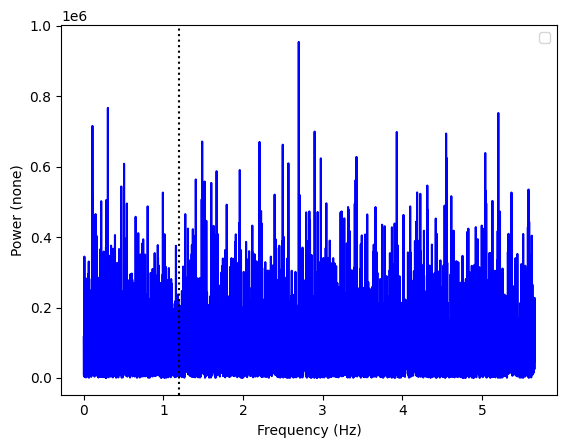

In [16]:
ax = Powerspectrum.from_stingray_timeseries(ts_polar, flux_attr="counts").plot()
ax.axvline(freq, ls=":", color="k")